In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, Add, Dot, Conv2DTranspose, Activation, Reshape, LeakyReLU, Flatten, BatchNormalization, Lambda, Softmax, Concatenate, Embedding, Multiply, Add
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from time import time
import os
import functools
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from tensorflow.python.ops import array_ops
from skimage.transform import resize
from keras.models import load_model

Using TensorFlow backend.


# **Spectral normalization Code**

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.engine.base_layer import Layer, InputSpec
from keras import backend as K
from keras.engine import *
from keras.legacy import interfaces
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils.generic_utils import func_dump
from keras.utils.generic_utils import func_load
from keras.utils.generic_utils import deserialize_keras_object
from keras.utils.generic_utils import has_arg
from keras.utils import conv_utils
from keras.legacy import interfaces
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
import tensorflow as tf

class DenseSN(Dense):
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                 initializer=initializers.RandomNormal(0, 1),
                                 name='sn',
                                 trainable=False)
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True
        
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                 W_bar = K.reshape(W_bar, W_shape)  
        output = K.dot(inputs, W_bar)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output 
        
class _ConvSN(Layer):

    def __init__(self, rank,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='valid',
                 data_format=None,
                 dilation_rate=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 spectral_normalization=True,
                 **kwargs):
        super(_ConvSN, self).__init__(**kwargs)
        self.rank = rank
        self.filters = filters
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, rank, 'dilation_rate')
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=self.rank + 2)
        self.spectral_normalization = spectral_normalization
        self.u = None
        
    def _l2normalize(self, v, eps=1e-12):
        return v / (K.sum(v ** 2) ** 0.5 + eps)
    
    def power_iteration(self, u, W):
        '''
        Accroding the paper, we only need to do power iteration one time.
        '''
        v = self._l2normalize(K.dot(u, K.transpose(W)))
        u = self._l2normalize(K.dot(v, W))
        return u, v
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        #Spectral Normalization
        if self.spectral_normalization:
            self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                                     initializer=initializers.RandomNormal(0, 1),
                                     name='sn',
                                     trainable=False)
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        
        if self.spectral_normalization:
            W_shape = self.kernel.shape.as_list()
            #Flatten the Tensor
            W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
            _u, _v = power_iteration(W_reshaped, self.u)
            #Calculate Sigma
            sigma=K.dot(_v, W_reshaped)
            sigma=K.dot(sigma, K.transpose(_u))
            #normalize it
            W_bar = W_reshaped / sigma
            #reshape weight tensor
            if training in {0, False}:
                W_bar = K.reshape(W_bar, W_shape)
            else:
                with tf.control_dependencies([self.u.assign(_u)]):
                    W_bar = K.reshape(W_bar, W_shape)

            #update weitht
            self.kernel = W_bar
        
        if self.rank == 1:
            outputs = K.conv1d(
                inputs,
                self.kernel,
                strides=self.strides[0],
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate[0])
        if self.rank == 2:
            outputs = K.conv2d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.rank == 3:
            outputs = K.conv3d(
                inputs,
                self.kernel,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0],) + tuple(new_space) + (self.filters,)
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_utils.conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding=self.padding,
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            return (input_shape[0], self.filters) + tuple(new_space)

    def get_config(self):
        config = {
            'rank': self.rank,
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(_Conv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
class ConvSN2D(Conv2D):

    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
                         initializer=initializers.RandomNormal(0, 1),
                         name='sn',
                         trainable=False)
        
      
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True
    def call(self, inputs, training=None):
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        #Spectral Normalization
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-1]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
                
        outputs = K.conv2d(
                inputs,
                W_bar,
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)
        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)
        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    

class ConvSN2DTranspose(Conv2DTranspose):

    def build(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError('Inputs should have rank ' +
                             str(4) +
                             '; Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (self.filters, input_dim)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
            
        # self.u = self.add_weight(shape=tuple([1, self.kernel.shape.as_list()[-1]]),
        #                  initializer=initializers.RandomNormal(0, 1),
        #                  name='sn',
        #                  trainable=False)
        self.u = self.add_weight(shape=tuple([1, self.filters]),
                        initializer=initializers.RandomNormal(0, 1),
                        name='sn',
                        trainable=False)
        
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True  
    
    def call(self, inputs):
        input_shape = K.shape(inputs)
        batch_size = input_shape[0]
        if self.data_format == 'channels_first':
            h_axis, w_axis = 2, 3
        else:
            h_axis, w_axis = 1, 2

        height, width = input_shape[h_axis], input_shape[w_axis]
        kernel_h, kernel_w = self.kernel_size
        stride_h, stride_w = self.strides
        if self.output_padding is None:
            out_pad_h = out_pad_w = None
        else:
            out_pad_h, out_pad_w = self.output_padding

        # Infer the dynamic output shape:
        out_height = conv_utils.deconv_length(dim_size = height,
                                                    kernel_size = kernel_h,
                                                    padding=self.padding,
                                                    output_padding=out_pad_h,
                                                    stride_size=stride_h,
                                                    dilation=self.dilation_rate[0])
        out_width = conv_utils.deconv_length(dim_size = width,
                                                    kernel_size = kernel_w,
                                                    padding=self.padding,
                                                    output_padding=out_pad_w,
                                                    stride_size=stride_w,
                                                    dilation=self.dilation_rate[1])
        if self.data_format == 'channels_first':
            output_shape = (batch_size, self.filters, out_height, out_width)
        else:
            output_shape = (batch_size, out_height, out_width, self.filters)

        output_shape_tensor = array_ops.stack(output_shape)   
        #Spectral Normalization    
        def _l2normalize(v, eps=1e-12):
            return v / (K.sum(v ** 2) ** 0.5 + eps)
        def power_iteration(W, u):
            #Accroding the paper, we only need to do power iteration one time.
            _u = u
            _v = _l2normalize(K.dot(_u, K.transpose(W)))
            _u = _l2normalize(K.dot(_v, W))
            return _u, _v
        W_shape = self.kernel.shape.as_list()
        #Flatten the Tensor
        W_reshaped = K.reshape(self.kernel, [-1, W_shape[-2]])
        _u, _v = power_iteration(W_reshaped, self.u)
        #Calculate Sigma
        sigma=K.dot(_v, W_reshaped)
        sigma=K.dot(sigma, K.transpose(_u))
        #normalize it
        W_bar = W_reshaped / sigma
        #reshape weight tensor
        if training in {0, False}:
            W_bar = K.reshape(W_bar, W_shape)
        else:
            with tf.control_dependencies([self.u.assign(_u)]):
                W_bar = K.reshape(W_bar, W_shape)
        self.kernel = W_bar
        
        outputs = K.conv2d_transpose(
            inputs,
            self.kernel,
            output_shape_tensor,
            self.strides,
            padding=self.padding,
            data_format=self.data_format)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs



class SelfAttentionGamma(Layer):

    def __init__(self,
                 **kwargs):
        super(SelfAttentionGamma, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        self.gamma = self.add_weight(shape=[1],
                                         name='gamma',
                                         initializer='zeros')
        self.built = True

    def call(self, inputs, training=None):
        # print(inputs[1].shape.as_list())
        # print(inputs[0].shape.as_list())
        return self.gamma*K.reshape(inputs[1], shape = K.shape(inputs[0])) + inputs[0]

    def get_config(self):
        config = {
        }
        base_config = super(SelfAttentionGamma, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        return input_shape[0]

**Mounting Google drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**GPU Memory**

In [0]:
# for resist GPU memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

**Loading data from keras**

In [0]:
from keras.datasets import cifar100, cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


**checking shape of the data set**

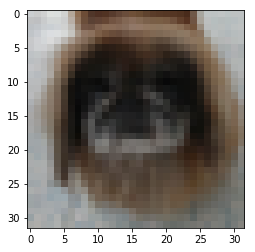

In [0]:
X = x_train
X.shape
plt.imshow(x_train[999])

**Declaring the variables and HyperParameters**

In [0]:
#Hyperperemeter
BATCHSIZE=64

LEARNING_RATE = 0.0002
#learning rates of generater and discriminator according to TTUR
LEARNING_RATE_G = 0.0001
LEARNING_RATE_D = 0.0002

TRAINING_RATIO = 1
BETA_1 = 0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.1
BN_EPSILON  = 0.0002


SAVE_IMG_DIR = '/content/drive/My Drive/DeepLearning/cSASNDCGAN2/img'
SAVE_LOGS_DIR = '/content/drive/My Drive/DeepLearning/cSASNDCGAN2/logs'
SAVE_LOSS_FID_LOGS = '/content/drive/My Drive/DeepLearning/cSASNDCGAN2/fid_logs'
model_save_dir = '/content/drive/My Drive/DeepLearning/cSASNDCGAN2/models'
model_save_interval = 1

Row_Num = 8

Size = Row_Num*Row_Num
steps = 1000


def mult1(x):
    x1 = x[0]
    x2 = x[1]
    x3 = K.permute_dimensions(x[1],pattern=(0,2,1))
    x4 = K.batch_dot(x1, x3, axes=(2,1))
    return x4

**ATTENTION CODE**

In [0]:
def Attention1(input):
    #Input is multiplied with Wf(conSN2D) weights to be trained -F-Layer
    SA_FLayer = ConvSN2D(128//8, kernel_size=1, strides=1,kernel_initializer='glorot_uniform', padding='same', activation=None)(input)
    SA_FLayer_ReShape = Lambda(lambda x:K.reshape(x, shape = (K.shape(x)[0], -1,K.shape(x)[3])))(SA_FLayer)
    
    #Input is multiplied with Wg(conSN2D) weights to be trained-G-Layer
    SA_GLayer = ConvSN2D(128//8, kernel_size=1, strides=1,kernel_initializer='glorot_uniform', padding='same', activation=None)(input)
    SA_GLayer_ReShape = Lambda(lambda x:K.reshape(x, shape = (K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2],K.shape(x)[-1])))(SA_GLayer)
        #Input is multiplied with Wh(conSN2D) weights to be trained-H-Layer
    SA_HLayer = ConvSN2D(128, kernel_size=1, strides=1,kernel_initializer='glorot_uniform', padding='same', activation=None)(input)
    SA_HLayer_ReShape = Lambda(lambda x:K.reshape(x, shape = (K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2],K.shape(x)[-1])))(SA_HLayer)
    
    #multiplying F and G and then applying softmax to get Beta
    multFG = Lambda(lambda x:mult1(x))([SA_GLayer_ReShape, SA_FLayer_ReShape])
 
    #featueMap Beta
    Attention_Map = Softmax(axis=-1)(multFG)

    #merge H-layer with the featureMap to generate all FeatueMaps
    attention = Lambda(lambda x:K.batch_dot(x[0], x[1], axes=(2, 1)))([Attention_Map, SA_HLayer_ReShape])

    attention_final = SelfAttentionGamma()([input, attention])
    
    return attention_final

**GENERATOR CODE**

In [0]:
 def BuildGenerator():

    label = Input(shape=(10,))
    noise = Input(shape=(128,))

    merge = Concatenate(name = 'l4')([noise, label])
    inter = Dense(4*4*512, kernel_initializer='glorot_uniform', name = 'l5')(merge)
    inter = Reshape((4,4,512), name = 'l6')(inter)
    
    inter = ConvSN2DTranspose(256, kernel_size=4, strides=2, padding='same', kernel_initializer='glorot_uniform', activation = None, name = 'l7')(inter)
    inter = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM, name = 'l8')(inter)
    inter = Activation('relu', name = 'l9')(inter)
    
    inter = ConvSN2DTranspose(128, kernel_size=4, strides=2, padding='same', kernel_initializer='glorot_uniform',activation = None, name = 'l10')(inter)
    inter = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM, name = 'l11')(inter)
    inter = Activation('relu', name = 'l12')(inter)

    attention_final = Attention1(inter)
    

    inter = ConvSN2DTranspose(64,  kernel_size=4, strides=2, padding='same', kernel_initializer='glorot_uniform',activation = None, name = 'l15')(attention_final)
    inter = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM, name = 'l16')(inter)
    inter = Activation('relu', name = 'l17')(inter)
    
    output = ConvSN2DTranspose(3,   kernel_size=3, strides=1, padding='same', activation='tanh', name = 'l18')(inter)
    
    gen_model = Model([noise, label], output)
    gen_model.summary()
    return gen_model


**DISCRMINATOR CODE**

In [0]:
def BuildDiscriminator():

    label = Input(shape=(10,))
    input = Input(shape=(32,32,3))
    
    inter = ConvSN2D(64, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(input)
    inter = LeakyReLU(0.1)(inter)
    inter = ConvSN2D(64, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same')(inter)
    inter = LeakyReLU(0.1)(inter)

    inter = ConvSN2D(128, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(inter)
    inter = LeakyReLU(0.1)(inter)

    
    attention_final = Attention1(inter)
    
    inter = ConvSN2D(128, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same')(attention_final)
    inter = LeakyReLU(0.1)(inter)

    inter = ConvSN2D(256, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(inter)
    inter = LeakyReLU(0.1)(inter)
    inter = ConvSN2D(256, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same')(inter)
    inter = LeakyReLU(0.1)(inter)

    inter = ConvSN2D(512, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(inter)
    inter = LeakyReLU(0.1)(inter)
    inter = Flatten()(inter)
    
    merged_layer = Concatenate()([inter, label])
    inter = DenseSN(512, activation='relu')(merged_layer)
    
    output  = DenseSN(1,kernel_initializer='glorot_uniform')(inter)
    
    model = Model([input, label], output)
    model.summary()
    return model

**Build Generator and Discrminator**

In [0]:
discriminator = BuildDiscriminator()
generator = BuildGenerator()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_s_n2d_14 (ConvSN2D)        (None, 32, 32, 64)   1856        input_6[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 32, 32, 64)   0           conv_s_n2d_14[0][0]              
__________________________________________________________________________________________________
conv_s_n2d_15 (ConvSN2D)        (None, 16, 16, 64)   65664       leaky_re_lu_8[0][0]              
____________________________________________________________________________________________

**HINGE LOSS FUNCTION**

In [0]:
def hinge_G_loss(y_true, y_pred):
    return -K.mean(y_pred)

def hinge_D_real_loss(y_true, y_pred):
    return K.mean(K.relu(1-y_pred))

def hinge_D_fake_loss(y_true, y_pred):
    return K.mean(K.relu(1+y_pred))

**Declaring the  generator && Discriminator**

In [0]:
Real_image                             = Input(shape=(32,32,3))
Real_label                             = Input(shape = (10,))
Noise_input_for_training_discriminator, Fake_label = generator.input
Fake_image                             = generator([Noise_input_for_training_discriminator, Fake_label])
Discriminator_output_for_real          = discriminator([Real_image, Real_label])
Discriminator_output_for_fake          = discriminator([Fake_image, Fake_label])

model_for_training_discriminator       = Model([Real_image, Real_label,
                                                Noise_input_for_training_discriminator, Fake_label],
                                               [Discriminator_output_for_real,
                                                Discriminator_output_for_fake])
gan                                    = Model([Noise_input_for_training_discriminator, Fake_label], Discriminator_output_for_fake)

**Load the weights of the model which are trained already**

In [0]:
discriminator.load_weights('/content/drive/My Drive/DeepLearning/cSASNDCGAN/modelsdiscriminator_model_weights_92.h5')
gan.load_weights('/content/drive/My Drive/DeepLearning/cSASNDCGAN/modelsgan_model_weights_92.h5')
generator.load_weights('/content/drive/My Drive/DeepLearning/cSASNDCGAN/modelsgenerator_model_weights_92.h5')

**Compile the Model(Generator && Discriminator)**

In [0]:

generator.trainable = False
discriminator.trainable = True
model_for_training_discriminator.compile(optimizer=Adam(LEARNING_RATE_D*TRAINING_RATIO, beta_1=BETA_1, beta_2=BETA_2), loss=[hinge_D_real_loss, hinge_D_fake_loss])
model_for_training_discriminator.summary()
discriminator.trainable = False
generator.trainable = True
gan.compile(optimizer=Adam(LEARNING_RATE_G, beta_1=BETA_1, beta_2=BETA_2), loss=hinge_G_loss)
gan.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 10)           0                                            
___________________________________________________________________________________________

**Check Point**

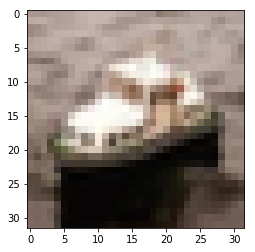

In [0]:
X = X/255*2-1
plt.imshow((X[8787]+1)/2)

**Functions needed in the Model**

In [0]:
def one_hot_encode(y):
    z = np.zeros((len(y), 10))
    idx = np.arange(len(y))
    z[idx, y] = 1
    return z

def generate_random_labels(n):
    y = np.random.choice(10, n)
    y = one_hot_encode(y)
    return y
  
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
  
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

**Functions to save weights and Files**

In [0]:

logs_loss = open(SAVE_LOGS_DIR + "logs_" + str(19) + ".txt", 'w')
logs_fid_loss = open(SAVE_LOSS_FID_LOGS + "logs_" + str(19) + ".txt", 'w')
def log_write(file, data):
    for values in data:
        file.write(str(values) + '\t')
    file.write('\n')
def save_models(generator, discriminator, gan, epoch_no, model_save_dir = model_save_dir):
        discriminator.trainable = True
        save_model(discriminator, model_save_dir + 'discriminator_model', epoch_no)
        generator.trainable = True
        save_model(generator, model_save_dir + 'generator_model', epoch_no)
        discriminator.trainable = False
        save_model(gan, model_save_dir + 'gan_model', epoch_no)
        
def save_model(model, model_path, epoch_no):
        with open(str(model_path) + '_' + str(epoch_no) + '.json', 'w') as json_file:
            json_file.write(model.to_json())

        with open(str(model_path) + '.json', 'w') as json_file:
            json_file.write(model.to_json())
            
        model.save_weights(str(model_path + '_' + "weights_" + str(epoch_no) + '.h5'))
        model.save_weights(str(model_path + '_' + "weights" + '.h5'))
        
        model.save(str(model_path+ '.h5')) 



**Function to calculate FID**

In [0]:
# loading Inception
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
# mean1 and sigma1 for Xtest
np.random.shuffle(x_test)
n_batches = int(np.ceil(float(x_test.shape[0]) / BATCHSIZE))
act = np.zeros([x_test.shape[0], 2048], dtype = np.float32)
for i in range(n_batches):
  inp = x_test[i * BATCHSIZE : (i + 1) * BATCHSIZE]
  size = 299
  inp = inp.astype('float32')
  inp = scale_images(inp, (299,299,3))
  inp = preprocess_input(inp)
  activations = inception.predict(inp)
  act[i * BATCHSIZE : i * BATCHSIZE + min(BATCHSIZE, inp.shape[0])] = activations
f1 = act
mean1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)

fid_label_one = one_hot_encode(y_test[:,0])
def generateFID():
      samples = np.zeros((10000, 32, 32, 3))
      noOf_batches = 20
      n = 0
      for btch in range(noOf_batches):
          sample_fid = np.random.randn(500, 128)
          samples[n:(n+500)] = generator.predict([sample_fid,fid_label_one[n:(n+500)]])
          n += 500

      samples = (samples + 1.) * 127.5

     
      #Generate Activations
      n_batches = int(np.ceil(float(samples.shape[0]) / BATCHSIZE))
      act = np.zeros([samples.shape[0], 2048], dtype = np.float32)
      for i in range(n_batches):
        inp = samples[i * BATCHSIZE : (i + 1) * BATCHSIZE]
        size = 299
        inp = inp.astype('float32')
        inp = scale_images(inp, (299,299,3))
        inp = preprocess_input(inp)
        activations = inception.predict(inp)
        act[i * BATCHSIZE : i * BATCHSIZE + min(BATCHSIZE, inp.shape[0])] = activations
      f2 = act
      mean2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
      sum_sq_diff = np.sum((mean1 - mean2)**2)
      cov_mean = sqrtm(sigma1.dot(sigma2))
      if np.iscomplexobj(cov_mean):
          cov_mean = cov_mean.real
      fid = sum_sq_diff + np.trace(sigma1 + sigma2 - 2.0*cov_mean)
      
      return fid
  



87916544/87910968 [==============================] - 3s 0us/step


**Creating Real and Fake labels**

In [0]:

real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = -real_y
true_label = one_hot_encode(y_train[:,0])
print(true_label.shape)
real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = -real_y
fid_label = one_hot_encode(y_test[:,0])
print(fid_label.shape)

(50000, 10)
(10000, 10)


**RUN this Cell to see Generator OutPut**

**NOTE:Please run all the above cells sequentially**
**and give correct path while running loadweight cell**

plot generated_image  waiting to calculate FID
32.44780543322018


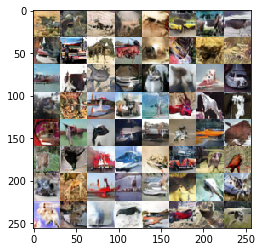

In [0]:
test_noise = np.random.randn(64, 128)
test_label = randint(low = 10, size = Size).reshape(-1, 1)
test_label_one_coded = one_hot_encode(test_label[:,0])

generated_image = generator.predict([test_noise,test_label_one_coded])
generated_image = (generated_image + 1)/2
for i in range(8):
    new = generated_image[i*8:i*8+8].reshape(32*8,32,3)
    if i!=0:
        old = np.concatenate((old,new),axis=1)
    else:
        old = new
print('plot generated_image  waiting to calculate FID considering 10,000 images')
plt.imshow(old)
print(generateFID())

**Train the data upto 500 epochs**

In [0]:

#training the model
test_noise = np.random.randn(Size, 128)
test_label = randint(low = 10, size = Size).reshape(-1, 1)
test_label_one_coded = one_hot_encode(test_label[:,0])

D_real = []
D_fake = []
D_loss = []
G_loss = []

d_real_perepoch = []
d_fake_perepoch = []
d_loss_perepoch = []
g_loss_perepoch = []

FID = []
fid = 0
counter = 0

for epoch in range(EPOCHS):
    X_shuffled, true_label_shuffled = unison_shuffled_copies(X, true_label)
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X.shape[0] // BATCHSIZE)
    #PROGRESS BAR 
    print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    progress_bar = Progbar(target=int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO)), width=20)
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    start_time = time()
    
    
    #TRAIN MODEL ON MINI BATCHES
    for index in range(int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        discriminator_minibatches = X_shuffled[index * minibatches_size:(index + 1) * minibatches_size]
        true_label_minibatches = true_label_shuffled[index * minibatches_size:(index + 1) * minibatches_size]
        
        for j in range(TRAINING_RATIO):
            image_batch = discriminator_minibatches[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            label_batch = true_label_minibatches[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
            random_labels = generate_random_labels(BATCHSIZE)
            discriminator.trainable = True
            generator.trainable = False
            generated_image = generator.predict([noise, label_batch])
            # print(generated_image.shape)
            err_real, err_fake, s_err = model_for_training_discriminator.train_on_batch([image_batch, label_batch, noise, label_batch], [real_y, fake_y])

            err_total = 0.5*(err_real + err_fake)
            D_loss.append(err_total)
            D_real.append(err_real)
            D_fake.append(err_fake)
        discriminator.trainable = False
        generator.trainable = True
        
        err_g = gan.train_on_batch([np.random.randn(BATCHSIZE, 128), random_labels], real_y)
        G_loss.append(err_g)
        log_write(logs_fid_loss, [err_real, err_fake, err_total, err_g])
        counter +=1
        
        
        #CALCULATE THE FID
        if(np.mod(counter, steps) == 0):

            fid = generateFID()
            FID.append(fid)
            log_write(logs_loss, [FID])

    if epoch != 0 and epoch % model_save_interval == 0:
                save_models(generator, discriminator, gan, epoch)
    #SAVE THE LOSSES
    print('\nepoch time: {}'.format(time()-start_time))
    print("fid: {}".format(fid))
    d_real_perepoch.append(err_real)
    d_fake_perepoch.append(err_fake)
    d_loss_perepoch.append(err_total)
    g_loss_perepoch.append(err_g)

    
    
    
    print("d_real_loss:{} d_fake_loss:{} d_loss:{} g_loss:{}".format(d_real_perepoch[-1], d_fake_perepoch[-1], d_loss_perepoch[-1], g_loss_perepoch[-1]))
     #Generate image
    generated_image = generator.predict([test_noise, test_label_one_coded])
    generated_image = (generated_image + 1)/2
    for i in range(Row_Num):
        new = generated_image[i*Row_Num:i*Row_Num+Row_Num].reshape(32*Row_Num,32,3)
        if i!=0:
            old = np.concatenate((old,new),axis=1)
        else:
            old = new
    print('plot generated_image')
    plt.imsave(SAVE_IMG_DIR + 'SN_epoch_{}.png'.format(epoch), old)
    
    
logs_loss.close()
logs_fid_loss.close()
    

epoch 1 of 500
number of batches: 781
  0/781 [....................] - ETA: 0sWARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1375: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


780/781 [==================>.] - ETA: 0s
epoch time: 296.6158056259155
fid: 0
d_real_loss:1.1569654941558838 d_fake_loss:0.848095715045929 d_loss:1.002530574798584 g_loss:0.30459174513816833
plot generated_image
epoch 2 of 500
number of batches: 781
780/781 [==================>.] - ETA: 0s
epoch time: 505.8194625377655
fid: 29.47536807622256
d_real_loss:1.2848169803619385 d_fake_loss:0.9950218796730042 d_loss:1.139919400215149 g_loss:0.3114432990550995
plot generated_image
epoch 3 of 500
number of batches: 781
780/781 [==================>.] - ETA: 0s
epoch time: 491.0525813102722
fid: 34.33058602090942
d_real_

Using TensorFlow backend.
